# UNIVARIATE SERIES FORECASTING.
Notebook to prepare the TennsorFlow Certified Developer.


Dataset from: https://opendata-ajuntament.barcelona.cat/data/en/dataset/temperatures-hist-bcn/resource/0e3b6840-7dff-4731-a556-44fac28a7873

Some inspiration from: 
https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting

## Import libraries

In [1]:
#First steep is import the libraries. 
import tensorflow as tf
tf.random.set_seed(42)
#Numpy is a lybrary that allow us to work with arrays. 
import numpy as np
#keras is an open source neural networks lybrary writted in python that run's in varios frameworks, TensorFlow included. 
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import csv

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import linregress

#Tranfer learning from tensorhub
import tensorflow_hub as hub

print (tf.__version__)

gEpochs = 100

2.9.0


# Functions


In [2]:
#clear the text 
import re
def cleanText(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

In [37]:
def get_model(kindmodel):
    switcher = {
        #LSTM Bidirectionsl
        0:tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                     strides=1,
                     activation="relu",
                     padding='causal',
                     input_shape=[C.WINDOW_SIZE, 1]),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1)]),
        #Don't work
        1:tf.keras.models.Sequential([
            tf.keras.layers.Dense(100, activation='relu', input_shape=[C.WINDOW_SIZE, 1]), 
            tf.keras.layers.Dense(1)]),
        #convolutiona + Maxpooling
        2:tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=64, kernel_size=2,
                     activation="relu",
                     input_shape=[C.WINDOW_SIZE, 1]), 
            tf.keras.layers.MaxPooling1D(pool_size=2), 
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(50, activation='relu'), 
            tf.keras.layers.Dense(1)]), 
        3:tf.keras.models.Sequential([
            tf.keras.layers.LSTM(50, activation='relu', input_shape=[C.WINDOW_SIZE, 1]), 
            tf.keras.layers.Dense(1)]), 
        
    }
    return switcher.get(kindmodel, None)

In [4]:

def plot_loss_acc(history, validation=True):
    
    '''Plots the training and validation loss and accuracy from a history object'''
    if (validation):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'bo-', label='Training accuracy')
        plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.figure()

        plt.plot(epochs, loss, 'bo-', label='Training Loss')
        plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()
    else:
        acc = history.history['accuracy']
       
        loss = history.history['loss']


        epochs = range(len(acc))

        plt.plot(epochs, acc, 'bo-', label='Training accuracy')

        plt.title('Training accuracy')
        plt.legend()

        plt.figure()


        plt.plot(epochs, loss, 'bo-', label='Training Loss')
        plt.title('Training and  loss')
        plt.legend()

        plt.show() 

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### prepare the data for the model

In [8]:
bcntmp = './Data/temperaturesbarcelonadesde1780.csv'


In [9]:
with open(bcntmp, 'r') as csvfile: 
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

Any,Temp_Mitjana_Gener,Temp_Mitjana_Febrer,Temp_Mitjana_Marc,Temp_Mitjana_Abril,Temp_Mitjana_Maig,Temp_Mitjana_Juny,Temp_Mitjana_Juliol,Temp_Mitjana_Agost,Temp_Mitjana_Setembre,Temp_Mitjana_Octubre,Temp_Mitjana_Novembre,Temp_Mitjana_Desembre

First data point looks like this:

1780,6.7,7.3,11.6,11.4,16.3,19.1,21.4,22,20.3,16.3,9.2,7.3

Second data point looks like this:

1781,7.5,8.9,10.9,13.7,16.8,18,22,22.6,19.1,15,11.8,10.3



In [10]:
def parse_data_from_file(filename):
    seq = []
    temperatures = []
    
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        n = 0
        for row in reader:
            n2=1
            while n2 <= 12:
                seq.append(n)
                temperatures.append(float(row[n2]))
                n2=n2+1
                n=n+1
 
            
    print(n)            
    return seq, temperatures
    
    

2904


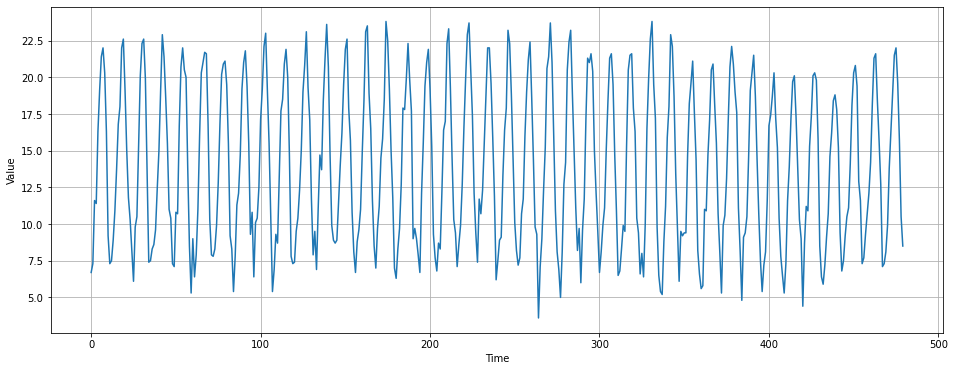

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
10.8


numpy.float64

In [11]:
class C:
    tempfile = bcntmp
    times, temperatures = parse_data_from_file(tempfile)
    
    time = np.array(times)
    series = np.array(temperatures)
    
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000
    

plt.figure(figsize=(16, 6))

plot_series(C.times[:480], C.series[:480])
plt.show()
print (C.time[:50])
print (C.series[50])

type(C.series[3])

In [12]:
def train_val_split(time, series, time_step=C.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    
    #print (len(series))
    return time_train, series_train, time_valid, series_valid

In [13]:
time_train, series_train, time_valid, series_valid = train_val_split(C.times, C.series)

In [14]:
print(series_train[20:])

[19.1 15.  11.8 ...  8.6 11.2 13.1]


In [15]:
def windowed_dataset(series, window_size=C.WINDOW_SIZE, batch_size=C.BATCH_SIZE, shuffle_buffer=C.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [16]:
train_set = windowed_dataset(series_train)

Metal device set to: Apple M1 Pro


2022-08-04 10:55:25.553529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-04 10:55:25.553889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model 0

In [17]:
model0 = get_model(0)

try:
    model0.predict(train_set)
except:
    print("Architecture and dataset incompatible")
else:
    print("compatible! Congrats!")

2022-08-04 10:55:26.005954: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-04 10:55:26.254250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 10:55:26.399046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


      4/Unknown - 1s 18ms/step 

2022-08-04 10:55:26.510503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 59ms/step
compatible! Congrats!


In [36]:
model0.compile(loss=tf.keras.losses.Huber(), optimizer="Adam", metrics=["mae"])
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 64, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68,575
Trainable params: 68,575
Non-traina

In [19]:
history0 = model0.fit(train_set, epochs=gEpochs)

Epoch 1/100


2022-08-04 10:55:28.357233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 10:55:28.610157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 10:55:28.694859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 10:55:28.849506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 10:55:29.038798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 77ms/step - loss: 12.4621 - mae: 12.9621
Epoch 2/100
10/10 [==============================] - 0s 33ms/step - loss: 8.9885 - mae: 9.4849
Epoch 3/100
10/10 [==============================] - 0s 34ms/step - loss: 5.8844 - mae: 6.3591
Epoch 4/100
10/10 [==============================] - 0s 34ms/step - loss: 4.4352 - mae: 4.9183
Epoch 5/100
10/10 [==============================] - 0s 33ms/step - loss: 4.3149 - mae: 4.8008
Epoch 6/100
10/10 [==============================] - 0s 33ms/step - loss: 4.3498 - mae: 4.8345
Epoch 7/100
10/10 [==============================] - 0s 33ms/step - loss: 4.3120 - mae: 4.7983
Epoch 8/100
10/10 [==============================] - 0s 34ms/step - loss: 4.2889 - mae: 4.7776
Epoch 9/100
10/10 [==============================] - 0s 33ms/step - loss: 4.2801 - mae: 4.7690
Epoch 10/100
10/10 [==============================] - 0s 33ms/step - loss: 4.2466 - mae: 4.7352
Epoch 11/100
10/10 [==============================] - 0s 34

10/10 [==============================] - 0s 34ms/step - loss: 0.7558 - mae: 1.1604
Epoch 87/100
10/10 [==============================] - 0s 33ms/step - loss: 0.7388 - mae: 1.1467
Epoch 88/100
10/10 [==============================] - 0s 33ms/step - loss: 0.7186 - mae: 1.1245
Epoch 89/100
10/10 [==============================] - 0s 33ms/step - loss: 0.7185 - mae: 1.1232
Epoch 90/100
10/10 [==============================] - 0s 33ms/step - loss: 0.7502 - mae: 1.1607
Epoch 91/100
10/10 [==============================] - 0s 35ms/step - loss: 0.7152 - mae: 1.1259
Epoch 92/100
10/10 [==============================] - 0s 33ms/step - loss: 0.7182 - mae: 1.1264
Epoch 93/100
10/10 [==============================] - 0s 33ms/step - loss: 0.7388 - mae: 1.1471
Epoch 94/100
10/10 [==============================] - 0s 34ms/step - loss: 0.7147 - mae: 1.1205
Epoch 95/100
10/10 [==============================] - 0s 33ms/step - loss: 0.6982 - mae: 1.1039
Epoch 96/100
10/10 [==============================] -

In [20]:
forecast = model_forecast(model0, C.series, C.WINDOW_SIZE).squeeze()

forecast_valid = forecast[C.SPLIT_TIME - C.WINDOW_SIZE:-1]

2022-08-04 10:56:11.906547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 10:56:11.974658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-04 10:56:12.053895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 2s 18ms/step


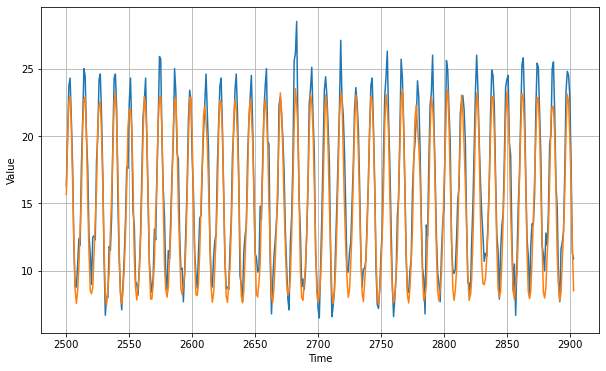

In [21]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, forecast_valid)

In [22]:
mse, mae = compute_metrics(series_valid, forecast_valid)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 3.20, mae: 1.43 for forecast


# Model 1

# Model 2

In [29]:
model2 = get_model(2)

try:
    model2.predict(train_set)
except:
    print("Architecture and dataset incompatible")
else:
    print("compatible! Congrats!")

10/10 [==============================] - 0s 6ms/step
compatible! Congrats!


2022-08-04 10:56:52.667236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [35]:
model2.compile(loss="mse", optimizer="Adam", metrics=["mae"])
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 63, 64)            192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 31, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1984)              0         
                                                                 
 dense_19 (Dense)            (None, 50)                99250     
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 99,493
Trainable params: 99,493
Non-trainable params: 0
__________________________________________________

In [31]:
history2 = model2.fit(train_set, epochs=gEpochs)

Epoch 1/100
      1/Unknown - 0s 325ms/step - loss: 156.9464 - mae: 11.3294

2022-08-04 10:56:55.615076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 13ms/step - loss: 46.2804 - mae: 5.3091
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 5.7052 - mae: 1.9209
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 4.0141 - mae: 1.6067
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 2.3651 - mae: 1.2353
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 2.2439 - mae: 1.1819
Epoch 6/100
10/10 [==============================] - 0s 11ms/step - loss: 1.9985 - mae: 1.1189
Epoch 7/100
10/10 [==============================] - 0s 10ms/step - loss: 1.9366 - mae: 1.1042
Epoch 8/100
10/10 [==============================] - 0s 12ms/step - loss: 1.9028 - mae: 1.0955
Epoch 9/100
10/10 [==============================] - 0s 10ms/step - loss: 1.8809 - mae: 1.0888
Epoch 10/100
10/10 [==============================] - 0s 11ms/step - loss: 1.8698 - mae: 1.0866
Epoch 11/100
10/10 [==============================] - 0s 10m

10/10 [==============================] - 0s 11ms/step - loss: 1.7510 - mae: 1.0551
Epoch 87/100
10/10 [==============================] - 0s 11ms/step - loss: 1.6400 - mae: 1.0133
Epoch 88/100
10/10 [==============================] - 0s 10ms/step - loss: 1.6650 - mae: 1.0222
Epoch 89/100
10/10 [==============================] - 0s 11ms/step - loss: 1.6846 - mae: 1.0234
Epoch 90/100
10/10 [==============================] - 0s 11ms/step - loss: 1.6536 - mae: 1.0173
Epoch 91/100
10/10 [==============================] - 0s 10ms/step - loss: 1.6249 - mae: 1.0064
Epoch 92/100
10/10 [==============================] - 0s 10ms/step - loss: 1.6686 - mae: 1.0223
Epoch 93/100
10/10 [==============================] - 0s 11ms/step - loss: 1.6649 - mae: 1.0206
Epoch 94/100
10/10 [==============================] - 0s 10ms/step - loss: 1.6366 - mae: 1.0099
Epoch 95/100
10/10 [==============================] - 0s 10ms/step - loss: 1.6573 - mae: 1.0147
Epoch 96/100
10/10 [==============================] -

In [32]:
forecast = model_forecast(model2, C.series, C.WINDOW_SIZE).squeeze()

forecast_valid = forecast[C.SPLIT_TIME - C.WINDOW_SIZE:-1]

     65/Unknown - 0s 2ms/step

2022-08-04 10:57:13.852450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 0s 3ms/step


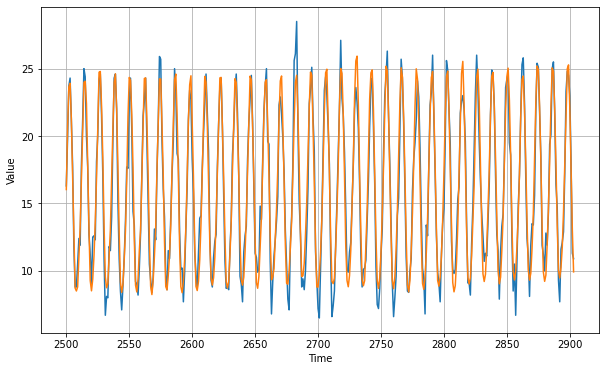

In [33]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, forecast_valid)

In [34]:
mse, mae = compute_metrics(series_valid, forecast_valid)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 1.96, mae: 1.11 for forecast


# Model 3


In [38]:
model3 = get_model(3)

try:
    model3.predict(train_set)
except:
    print("Architecture and dataset incompatible")
else:
    print("compatible! Congrats!")

2022-08-04 11:06:26.817851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 2s 163ms/step
compatible! Congrats!


In [40]:
model3.compile(loss="mse", optimizer="Adam", metrics=["mae"])
model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                10400     
                                                                 
 dense_28 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [41]:
history3 = model3.fit(train_set, epochs=gEpochs)

Epoch 1/100


2022-08-04 11:07:23.126396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 23s 2s/step - loss: 1526.2758 - mae: 36.0855
Epoch 2/100
10/10 [==============================] - 22s 2s/step - loss: 427.5190 - mae: 19.8962
Epoch 3/100
10/10 [==============================] - 22s 2s/step - loss: 314.7875 - mae: 17.1647
Epoch 4/100
10/10 [==============================] - 22s 2s/step - loss: 293.5321 - mae: 16.5692
Epoch 5/100
10/10 [==============================] - 22s 2s/step - loss: 241.5237 - mae: 14.9555
Epoch 6/100
10/10 [==============================] - 23s 2s/step - loss: 186.0955 - mae: 13.0731
Epoch 7/100
10/10 [==============================] - 23s 2s/step - loss: 116.7537 - mae: 10.0640
Epoch 8/100
10/10 [==============================] - 23s 2s/step - loss: 29.1417 - mae: 4.4311
Epoch 9/100
10/10 [==============================] - 23s 2s/step - loss: 9.9344 - mae: 2.5486
Epoch 10/100
10/10 [==============================] - 22s 2s/step - loss: 6.5744 - mae: 2.0691
Epoch 11/100
10/10 [============================

10/10 [==============================] - 23s 2s/step - loss: 1.7462 - mae: 1.0515
Epoch 88/100
10/10 [==============================] - 23s 2s/step - loss: 1.7284 - mae: 1.0446
Epoch 89/100
10/10 [==============================] - 23s 2s/step - loss: 1.7188 - mae: 1.0402
Epoch 90/100
10/10 [==============================] - 23s 2s/step - loss: 1.7569 - mae: 1.0538
Epoch 91/100
10/10 [==============================] - 23s 2s/step - loss: 1.7486 - mae: 1.0476
Epoch 92/100
10/10 [==============================] - 23s 2s/step - loss: 1.7220 - mae: 1.0418
Epoch 93/100
10/10 [==============================] - 23s 2s/step - loss: 1.7031 - mae: 1.0341
Epoch 94/100
10/10 [==============================] - 23s 2s/step - loss: 1.7082 - mae: 1.0394
Epoch 95/100
10/10 [==============================] - 23s 2s/step - loss: 1.7197 - mae: 1.0383
Epoch 96/100
10/10 [==============================] - 23s 2s/step - loss: 1.7113 - mae: 1.0411
Epoch 97/100
10/10 [==============================] - 23s 2s/st

In [42]:
forecast = model_forecast(model3, C.series, C.WINDOW_SIZE).squeeze()

forecast_valid = forecast[C.SPLIT_TIME - C.WINDOW_SIZE:-1]

2022-08-04 11:48:31.259236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 14s 161ms/step


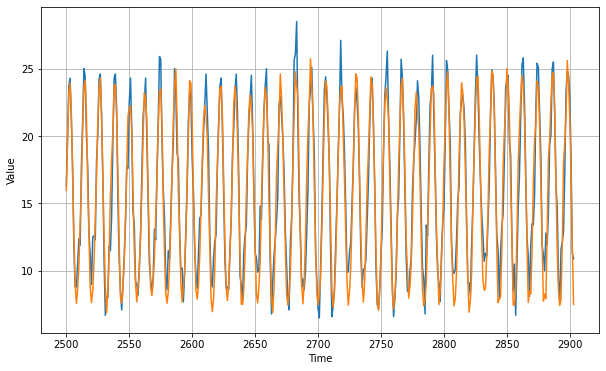

In [43]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, forecast_valid)

In [44]:
mse, mae = compute_metrics(series_valid, forecast_valid)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 2.95, mae: 1.33 for forecast
